<a href="https://colab.research.google.com/github/hijera/NN_colab_hw/blob/main/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_ARMA_(%D0%92%D0%BB%D0%B0%D1%81%D0%BE%D0%B2_%D0%90%D0%BD%D1%82%D0%BE%D0%BD).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание
1. Выберите ряд из первого задания.
2. Постройте его модель ARIMA.
3. Оформите отчёт в Jupyter-ноутбук.
4. Попробуйте спрогнозировать график классическим ML.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
# import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [ ]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))
        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return
def test_stationarity(timeseries):

    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    res_arr={}
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput

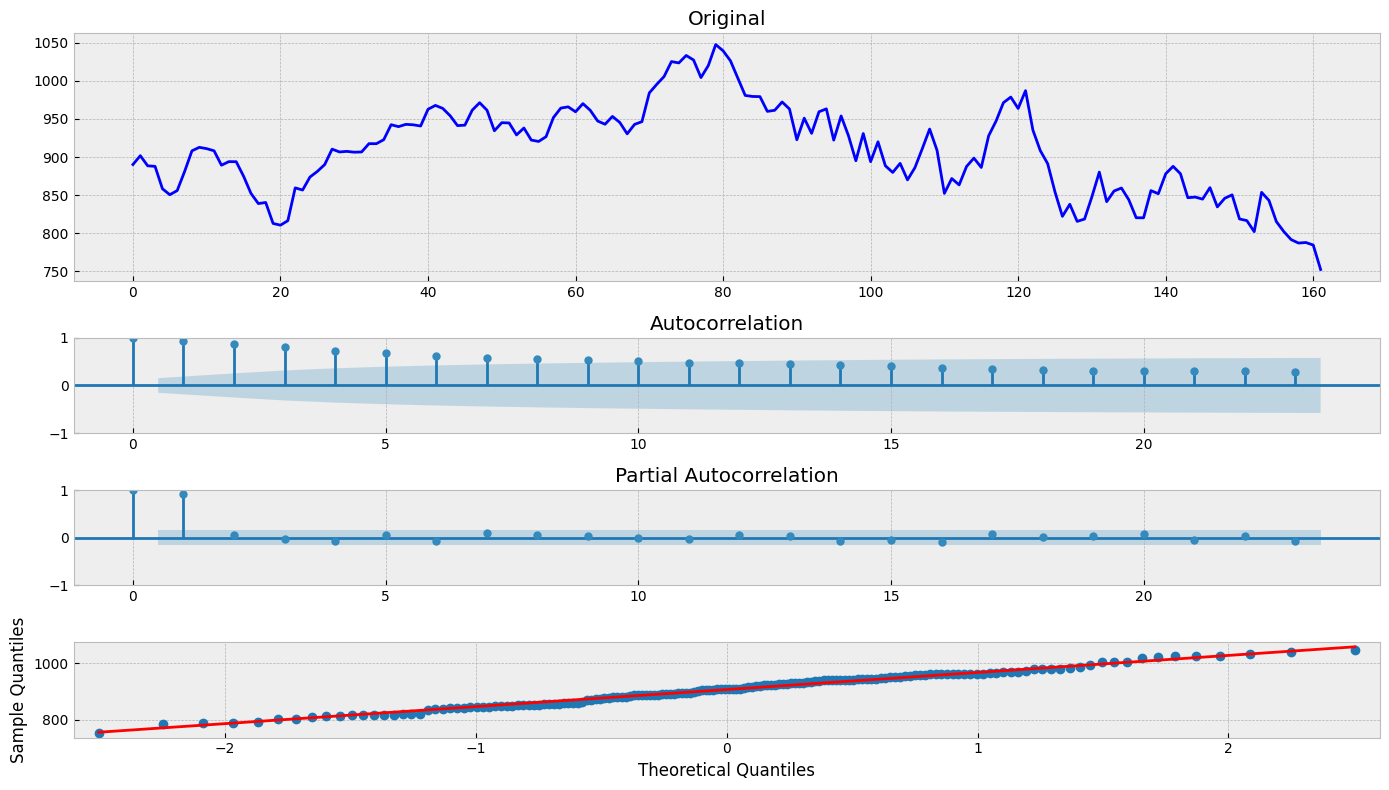

In [ ]:
#all_series = {
#    "Monthly sales of company X": sales_of_company_x["Count"],
#    "Monthly Boston armed robberies": robberies_in_boston["Count"],
#    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
#    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
#    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
#    "Daily total female births in California": female_births["Count"]
#}



series = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")['Close']
# series = series.astype('float64')
tsplot(series)



In [ ]:
test_stationarity(series)

Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64

In [ ]:
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = ARIMA(TS, order=(i,d,j)).fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

aic: -613.72879 | order: (4, 0, 3)


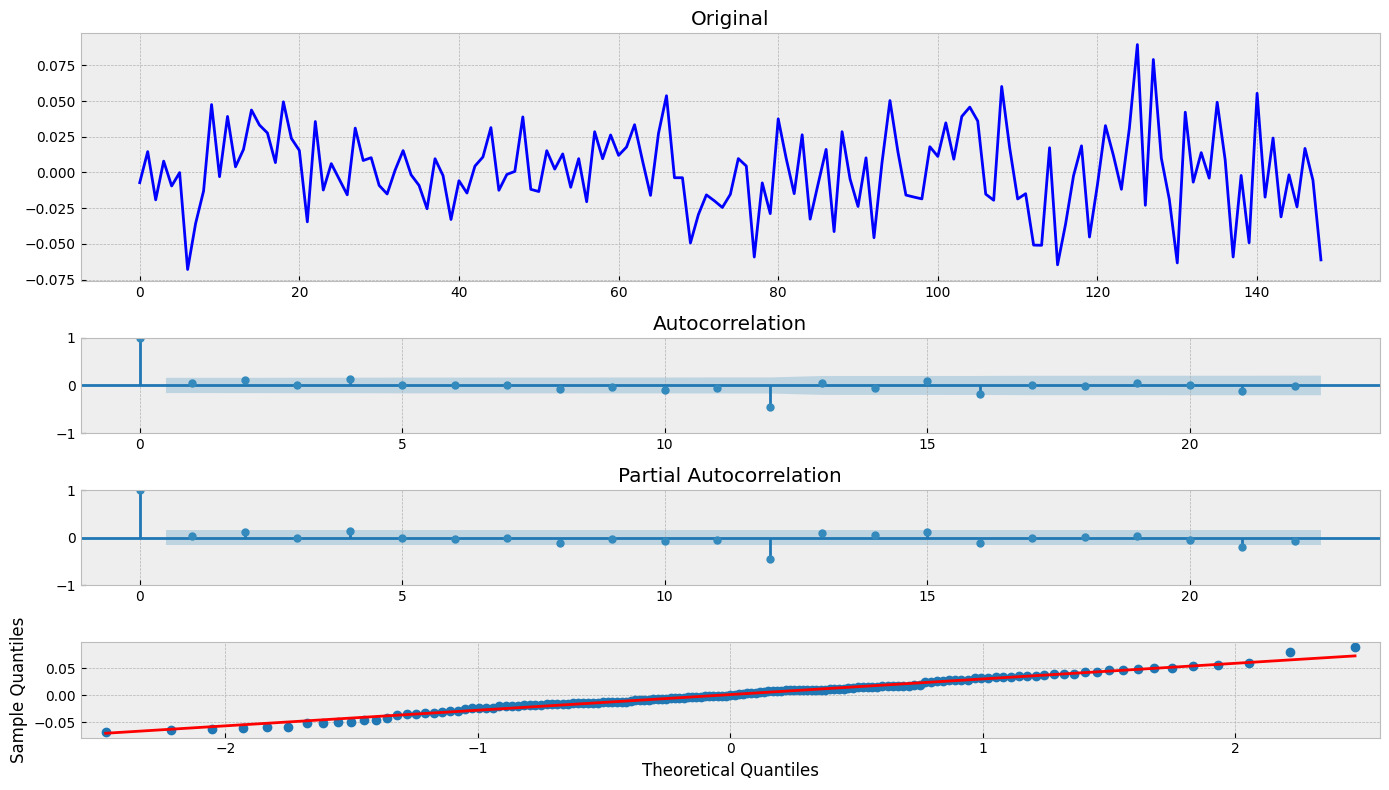

In [ ]:



warnings.filterwarnings("ignore")


series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]



aic, order, mdl = _get_best_model(series)



tsplot(mdl.resid)



In [ ]:
test_stationarity(series)

Test Statistic                  -3.433413
p-value                          0.009871
#Lags Used                      14.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64

In [ ]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15,param="Count"):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))




    # разбиваем весь датасет на тренировочную и тестовую выборку
    train = data.loc[:test_index]


    test = data.loc[test_index:]

    return train, test

In [ ]:
train , test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3,param="Close")

In [ ]:


model = ARIMA(train, order=order)
model_fit = model.fit()

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)


mse = mean_squared_error(test, predictions)
print("MSE: "+str(mse))

MSE: 0.0017222956859177115


Попробуем предсказать несколько следующих значений на основе обученной модели

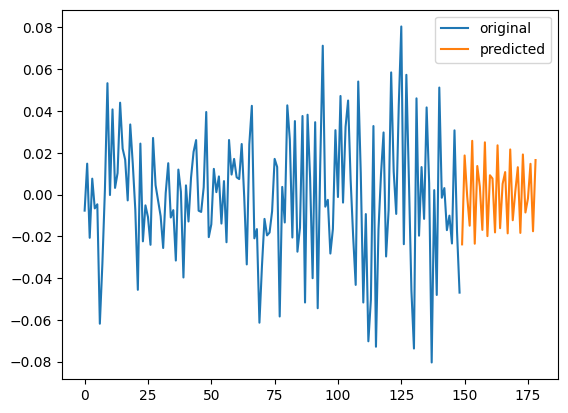

In [ ]:
forecast = model_fit.forecast(steps=30)
plt.plot(series, label='original')
plt.plot(pd.RangeIndex(start=len(series), stop=len(series)+len(forecast)), forecast, label='predicted')
plt.legend()
plt.show()

Таким образом, мы смогли обучеть модель ARIMA с наиболее оптимальными параметрами и попробовали предсказать дальнейший временной ряд.

#Построение модели линейной регрессии

In [ ]:
series_l = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")

In [44]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data[0].shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
   # data = data.drop(["Month"], axis=1)
    print("data shape is "+str(data.shape[0]))
    # разбиваем весь датасет на тренировочную и тестовую выборку
#    X_train = data.loc[:test_index].drop([0], axis=1)
    y_train = data.loc[:test_index][0]
#    X_test = data.loc[test_index:].drop([0], axis=1)
    y_test = data.loc[test_index:][0]

    return X_train, X_test, y_train, y_test

In [54]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

data shape is 130


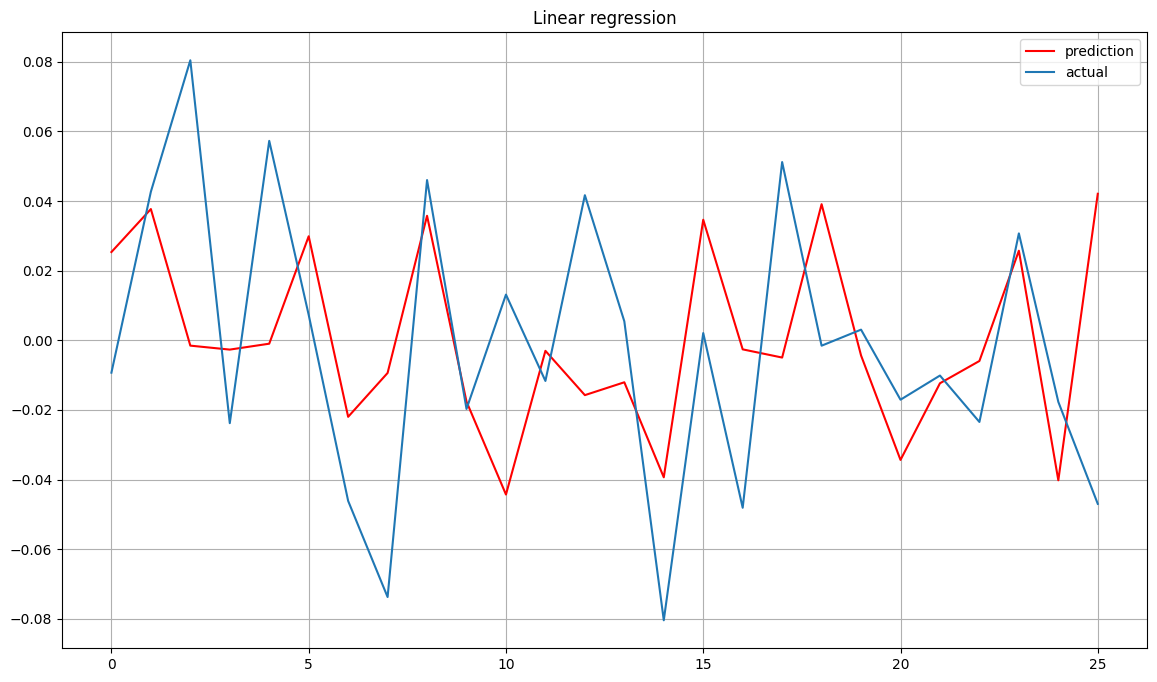

In [55]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
#plt.plot(series,label="full")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);